In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy.optimize import fsolve
%matplotlib inline

In [14]:
class Hamiltonian():
    def __init__(self, Npw,L,Znuc):
        self.Npw = Npw
        self.L = L
        self.dL = L/Npw
        self.dL_2 = L/(2 * Npw)
        # define G vectors
        self.Gvec = np.fft.fftfreq (Npw, d = self.dL) * (2 * np.pi)
        self.Gvec_2 = np.fft.fftfreq (2 * Npw, d = self.dL_2) * (2 * np.pi)
        # define Coulomb potential
        self.coulomb =  np.asarray([4* np.pi /g**2 if (np.abs(g)>1e-10) else 0
                                    for g in self.Gvec_2])
        
        # Coulomb attractive potential
        self.pos = 0.625 * L
        self.beta2 = 1.5**2
        self.Znuc = Znuc
        self.Nel = Znuc
        self.rhonuc_G = -(Znuc/L) * np.exp(1j * self.Gvec_2 * self.pos) \
                      * np.exp(-0.5 * self.Gvec_2**2 * self.beta2)

    def computeMat (self):
        self.hamMat = np.zeros(shape=(Npw,Npw),dtype=np.complex128)
        # kinetic energy
        np.fill_diagonal (self.hamMat, 0.5 * self.Gvec**2)
        # effective potential
        veff_G = np.fft.ifft(self.veff)
        ni = [ (i - self.Npw) if (2*i > self.Npw) else i
              for i in range(self.Npw) ]
        for ij in np.ndindex(self.hamMat.shape):
            dij = ni[ij[0]] - ni[ij[1]]
            if dij < 0: dij += 2*self.Npw
            self.hamMat[ij] += veff_G[dij]

    def computeRho (self, vals, vecs, Nel, kT):
        
        # find the Fermi energy
        beta = 1./kT
        fermi = lambda x: 1/(1 + np.exp(beta * x)) if (beta * x) < 50 else 0
        target = lambda mu: sum(fermi(eps-mu) for eps in vals) - Nel
        mu, = fsolve (target, x0 = vals[Nel])
        self.mu = mu
        
        # compute rho and kinetic energy
        self.Ekin = 0.
        rho=np.zeros(shape=2*self.Npw, dtype=np.float64)
        Npw2 = int (self.Npw/2)
        for i in np.ndindex(vals.shape):
            focc = fermi(vals[i]-mu)
            if focc > 1e-12:
                # get psi on large FFT mesh
                psi_expand = np.zeros(shape=(2*self.Npw),dtype=np.complex128)
                psi_expand[0:Npw2] = vecs[0:Npw2,i].flatten ()
                psi_expand[-Npw2:] = vecs[-Npw2:,i].flatten ()
                
                psi = np.fft.fft(psi_expand)/np.sqrt(self.L)
                # add to density
                rho += focc * (psi.real **2 + psi.imag ** 2)
                
                # compute kinetic energy contribution
                self.Ekin += focc * 0.5 * sum (
                            (c.real ** 2 + c.imag ** 2) * g ** 2
                             for c,g in zip(vecs[:,i].flatten (),
                                            self.Gvec)
                            )

        return rho

    def computePot(self, rho):
        rho_G = np.fft.ifft(rho)

        rho_G += self.rhonuc_G
        rho_G[0]=0.
        V_G = rho_G * self.coulomb
        vH = np.real (np.fft.fft(V_G))
        self.E_H = 0.5 * np.vdot(rho_G, V_G).real * self.L
        #self.E_H = 0.5 * sum(np.fft.fft(rho_G).real * vH) * self.dL_2

        # xc contribution via x-alpha
        alpha = -0.73855877 # -3/4 (3/pi)**(1/3)
        self.eXc = sum(r**(4./3.) for r in rho if r > 0) \
                 * alpha * self.dL_2
        vXc = (4./3.) * alpha * np.asarray ([r**(1./3.) if r > 0 else 0 for r in rho])

        self.veff = vH + vXc
        
        # External local potential
        if any(f == 'v_loc' for f in self.__dir__()):
            self.veff += self.v_loc
            self.eLoc = sum (self.v_loc * rho) * self.dL_2
        else:
            self.eLoc = 0.
            
    def getEnergy (self):
        return self.Ekin + self.eXc + self.E_H + self.eLoc

In [3]:
Npw = 100
L = 5
Nel=7
h = Hamiltonian(Npw,L,Nel)

1.0000000000000004
(-6.999999999999999+1.6562997521730228e-33j)


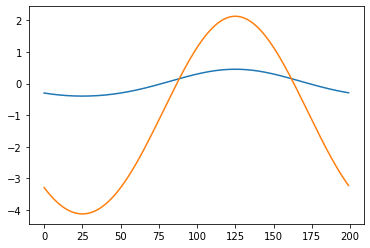

In [18]:
rho0b2=1.2**2
rho0_G = (1./L) * np.exp(1j * h.Gvec_2 * h.pos) \
              * np.exp(-0.5 * h.Gvec_2**2 * rho0b2)
rho0 = np.fft.fft(rho0_G).real
print (sum(rho0) * h.dL_2)

#print (np.fft.ifft(rho0)[0], h.rhonuc_G[0]/h.Znuc)
#plt.plot (rho0 * h.Nel)
#plt.plot (np.fft.fft(h.rhonuc_G).real)
plt.plot (rho0 * h.Nel + np.fft.fft(h.rhonuc_G).real)
print (sum(np.fft.fft(h.rhonuc_G))*h.dL_2)
h.computePot (rho0 * h.Nel)
plt.plot (h.veff)
rho0 *= h.Nel

In [5]:
#h.veff *= 0.
h.computeMat ()
#h.hamMat - h.hamMat.T.conj ()

In [6]:
vals,vecs = np.linalg.eigh(h.hamMat)
vals

array([-3.10666764e+00, -1.15915940e+00,  5.03805509e-01,  2.29945401e+00,
        2.73775131e+00,  6.21087072e+00,  6.21930852e+00,  1.16590527e+01,
        1.16590836e+01,  1.87287125e+01,  1.87287126e+01,  2.73945134e+01,
        2.73945134e+01,  3.76472770e+01,  3.76472770e+01,  4.94832951e+01,
        4.94832951e+01,  6.29008262e+01,  6.29008262e+01,  7.78989626e+01,
        7.78989626e+01,  9.44771923e+01,  9.44771923e+01,  1.12635209e+02,
        1.12635209e+02,  1.32372819e+02,  1.32372819e+02,  1.53689897e+02,
        1.53689897e+02,  1.76586357e+02,  1.76586357e+02,  2.01062140e+02,
        2.01062140e+02,  2.27117203e+02,  2.27117203e+02,  2.54751515e+02,
        2.54751515e+02,  2.83965053e+02,  2.83965053e+02,  3.14757799e+02,
        3.14757799e+02,  3.47129741e+02,  3.47129741e+02,  3.81080868e+02,
        3.81080868e+02,  4.16611171e+02,  4.16611171e+02,  4.53720644e+02,
        4.53720644e+02,  4.92409282e+02,  4.92409282e+02,  5.32677081e+02,
        5.32677081e+02,  

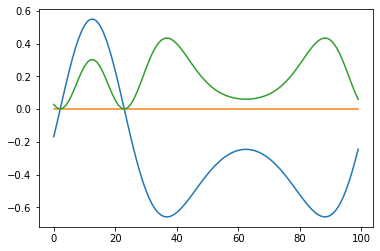

In [7]:
vec_r = np.fft.fft(vecs[:,2])/np.sqrt(L)
plt.plot (vec_r.real)
plt.plot (vec_r.imag)
plt.plot (vec_r.real **2 + vec_r.imag **2)

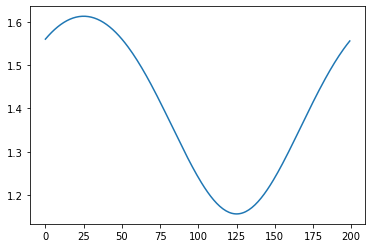

In [8]:

rho = h.computeRho(vals,vecs,Nel,1e-3)
plt.plot (rho)

In [9]:
def scf_cycle(ham,rho_in):
    ham.computePot (rho_in)
    ham.computeMat ()
    vals,vecs = np.linalg.eigh(ham.hamMat)
    return ham.computeRho(vals,vecs,Nel,1e-3)

In [19]:
rho_i = rho0
pre_scale = 0.8
allRes = []
allE = []
res_old=None
search_old=None
gamma = 0.
for i in range(50):
    rho_o = scf_cycle(h,rho_i)
    res = rho_o-rho_i
    resNorm = np.linalg.norm(res)
    allRes.append (resNorm)

    # recompute potential to get E_H, Exc from waves ...
    h.computePot (rho_o)
    # ... needed here to compute Kohn-Sham energy
    Etot = h.getEnergy ()
    print (i, "R=",resNorm, "E=",Etot)
    allE.append (Etot)

    # --- check for convergence
    if resNorm < 1e-8:
        break

    # conjugate-gradient for density (not sure this works in all cases!)
    # should be DIIS or MINRES
    search = res
    if search_old is not None:
        gamma = np.dot(res_old, res)/np.dot(res_old, res_old)
        search += gamma * search_old
    search_old = search
    res_old = res

    # line search
    rho_trial = rho_i + pre_scale * search
    resTrial = scf_cycle(h,rho_trial) - rho_trial
    step = -np.dot(resTrial-res, res) /np.dot(resTrial-res,resTrial-res)
    
    # optimal step
    rho_i = rho_i + step * pre_scale * search
    
    # dynamic adaptation of pre_scale
    if (step > 2):
        pre_scale *= 1.5
    elif (step < 0.5):
        pre_scale /= 1.5
    print (step, "prescale=",pre_scale,"gamma=", gamma)
    


0 R= 11.266662520218379 E= 22.09515587832349
0.8022780398561583 prescale= 0.8 gamma= 0.0
1 R= 0.064955076244608 E= 17.731149697153327
1.078142887436733 prescale= 0.8 gamma= 0.0004422580081637497
2 R= 0.007371740904228729 E= 17.7311412438446
0.8022597263221901 prescale= 0.8 gamma= 0.014877291763995572
3 R= 0.00039986666077901936 E= 17.731139468099514
1.0786085910163798 prescale= 0.8 gamma= -0.005626555566896859
4 R= 2.925313257735035e-05 E= 17.731139467517952
0.8441358453037544 prescale= 0.8 gamma= 0.008001431310811541
5 R= 5.09851747138336e-06 E= 17.731139467496803
1.107224081648225 prescale= 0.8 gamma= 0.023808842268348895
6 R= 1.9753956506196998e-07 E= 17.731139467496703
0.7992518480849742 prescale= 0.8 gamma= 0.006454588795663729
7 R= 3.766096120692644e-08 E= 17.731139467496703
1.1626214108931194 prescale= 0.8 gamma= 0.01624227690739514
8 R= 1.8342008187184644e-09 E= 17.731139467496686


In [16]:
rho_i = rho0
rho_mix=0.2
allRes = []
allE = []
res_old=None
search_old=None
gamma = 0.
for i in range(50):
    rho_o = scf_cycle(h,rho_i)
    res = rho_o-rho_i
    resNorm = np.linalg.norm(res)
    allRes.append (resNorm)

    # recompute potential to get E_H, Exc from waves ...
    h.computePot (rho_o)
    # ... needed here to compute Kohn-Sham energy
    Etot = h.getEnergy ()
    print (i, "R=",resNorm, "E=",Etot)
    allE.append (Etot)

    # --- check for convergence
    if resNorm < 1e-8:
        break

    # optimal step
    rho_i = rho_i + rho_mix * res    


0 R= 11.266662520218379 E= 22.09515587832349
1 R= 7.752565794426542 E= 19.79582129359851
2 R= 5.338888351749465 E= 18.71045703773447
3 R= 3.67740747454827 E= 18.195849405720807
4 R= 2.533073391987644 E= 17.951587526104515
5 R= 1.7449469532151667 E= 17.83566482598926
6 R= 1.2022492030884373 E= 17.780678682565352
7 R= 0.8286121213992688 E= 17.754610924466622
8 R= 0.5713879109029512 E= 17.742258063228356
9 R= 0.39429791681634613 E= 17.736406059492616
10 R= 0.2723564397758322 E= 17.733634202372752
11 R= 0.18836327543403364 E= 17.732321352862616
12 R= 0.13048183716868442 E= 17.731699512215616
13 R= 0.09056851267338861 E= 17.731404933292783
14 R= 0.0630212796096306 E= 17.7312653542704
15 R= 0.04398676251068406 E= 17.73119919750954
16 R= 0.03081443687195918 E= 17.731167827930204
17 R= 0.021681091816952193 E= 17.73115294541297
18 R= 0.015332506447861504 E= 17.731145879937106
19 R= 0.010905782657297193 E= 17.731142522695723
20 R= 0.007807158797237233 E= 17.73114092572382
21 R= 0.005627976265569

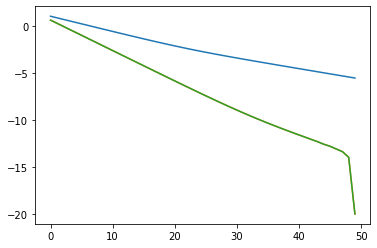

In [17]:
plt.plot (np.log10(allRes))
plt.plot (np.log10([dE if dE > 0 else 1e-20 for dE in allE-allE[-1]]))
plt.plot (np.log10([dE if dE > 0 else 1e-20-dE for dE in allE-allE[-1]]))

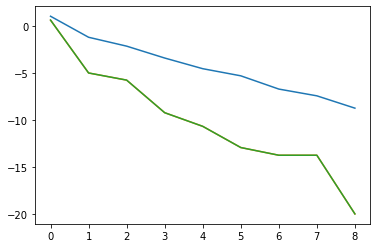

In [20]:
plt.plot (np.log10(allRes))
plt.plot (np.log10([dE if dE > 0 else 1e-20 for dE in allE-allE[-1]]))
plt.plot (np.log10([dE if dE > 0 else 1e-20-dE for dE in allE-allE[-1]]))

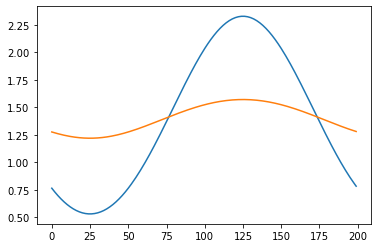

In [12]:
plt.plot(rho0)
plt.plot(rho_i)


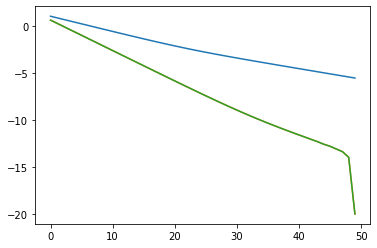

In [17]:
plt.plot (np.log10(allRes))
plt.plot (np.log10([dE if dE > 0 else 1e-20 for dE in allE-allE[-1]]))
plt.plot (np.log10([dE if dE > 0 else 1e-20-dE for dE in allE-allE[-1]]))

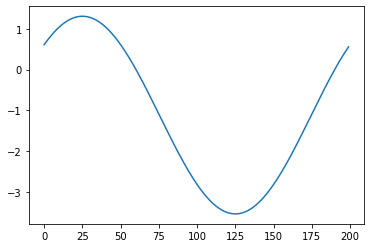

In [13]:
plt.plot(h.veff)